# Previsão do valor de mercado de um veículo


O serviço de vendas de carros usados Rusty Bargain está desenvolvendo um aplicativo para atrair novos clientes. Nesse aplicativo, você pode descobrir rapidamente o valor de mercado do seu carro. Você tem acesso a dados históricos: especificações técnicas, versões de acabamento e preços. Você precisa construir o modelo para determinar o valor. 

Rusty Bargain está interessado em:

- a qualidade da predição;
- a velocidade da predição;
- o tempo necessário para o treinamento.

## Importando Bibliotecas

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer

import category_encoders as ce
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [3]:
# Setando o estilo dos gráficos
sns.set_style("whitegrid", rc={"grid.linestyle": ":"})
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

## Preparação de Dados

### Lendo arquivo CSV

In [4]:
data = pd.read_csv('car_data.csv')

Imprimindo primeiras 10 linhas do dataframe

In [5]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17


**Características**

* <em>DateCrawled</em> — data em que o perfil foi baixado do banco de dados
* <em>VehicleType</em></em> — tipo de carroçaria do veículo
* <em>RegistrationYear</em> — ano de matrícula do veículo
* <em>Gearbox</em> — tipo de caixa de transmissão
* <em>Power</em> — potência (hp)
* <em>Model</em> — modelo do veículo
* <em>Mileage</em> — quilometragem (medida em km devido às especificidades regionais do conjunto de dados)
* <em>RegistrationMonth</em> — mês de registro do veículo
* <em>FuelType</em> — tipo de combustível
* <em>Brand</em> — marca do veículo
* <em>NotRepaired</em> — veículo reparado ou não
* <em>DateCreated</em> — data de criação do perfil
* <em>NumberOfPictures</em> — número de fotos do veículo
* <em>PostalCode</em> — código postal do proprietário do perfil (usuário)
* <em>LastSeen</em> — data da última atividade do usuário

**Objetivo**
* <em>Price</em> — preço (Euro)

### Variáveis do dataframe

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Formato do dataframe

In [7]:
data.shape

(354369, 16)

### Valores ausentes

In [8]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### Valores duplicados

In [9]:
data.duplicated().sum()

262

**Conclusões**


O dataset possiu 354369 e 14 colunas. As features armazenam informações sobre características do carro e informações do cadastro do veículo na plataforma de compra. 
Sobre a qualidade das informações, foram identificados alguns problemas, como valores ausentes, inconsistência no nome das variáveis, valores duplicados e variáveis com tipagens impróprias.

## Limpeza do dataframe

### Corrigindo nomeclatura das colunas

In [114]:
# Criar cópia do dataframe original
df_copy = data.copy()
df_copy.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [115]:
# Passando a nomeclatura das variáveis para snake_case
def camel_to_snake(column_name):
    # usando regex para encontrar todas as strings maiúsculas e minúculas e digitos no intervalo de 0 a 9.
    words = re.fheadindall('[A-Z][a-z0-9]*', column_name) 
    
    snake_case = '_'.join([word.lower() for word in words])
    
    return snake_case

In [116]:
# Função aplicada para cada nome de coluna no atributo columns
df_copy.columns = [camel_to_snake(col) for col in df_copy.columns]

In [82]:
# Verificando resultados
df_copy.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

### Valores ausentes

In [77]:
df_copy.isna().sum()

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
mileage                   0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
dtype: int64

In [183]:
# Imputando valores ausentes
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df_copy)
imputed_data = imputer.transform(df_copy)
df_copy = pd.DataFrame(imputed_data, columns=df_copy.columns)
df_copy.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


### Variáveis categóricas com muitas categorias

In [93]:
print(df_copy.vehicle_type.unique().__len__())

8


In [97]:
print(df_copy.model.unique().__len__())

250


In [98]:
print(df_copy.fuel_type.unique().__len__())

7


In [99]:
print(df_copy.brand.unique().__len__())

40


In [100]:
print(df_copy.not_repaired.unique().__len__())

2


##### Variável 'model'

In [222]:
df_copy.model.unique().__len__()

250

In [321]:
teste = df_copy.copy()

In [278]:
df = pd.DataFrame({'model': teste.model})

In [303]:
import prince
mca = prince.MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(df)

In [306]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,1.000,0.40%,0.40%
1,1.000,0.40%,0.80%
2,1.000,0.40%,1.20%


In [307]:
mca.row_coordinates(df).head()

,0,1,2
0,0.002069,0.046480,-0.006392
1,0.002069,0.046480,-0.006392
2,-1.429130,-0.717630,-1.477701
3,0.002069,0.046480,-0.006392
4,0.572796,1.042421,-0.210635


In [262]:
mca.column_coordinates(df).head()


,0,1,2
model_1 reihe,-0.140639,0.868844,0.710300
model_100,2.251466,-0.682521,2.677823
model_145,4.391231,0.140089,-11.106869
model_147,1.109599,-0.575093,0.484579
model_156,1.182433,-0.455703,1.267511


In [263]:
mca.row_contributions_.head().style.format('{:.0%}')

,0,1,2
0,0%,0%,0%
1,0%,0%,0%
2,0%,0%,0%
3,0%,0%,0%
4,0%,0%,0%


In [304]:
mca.column_contributions_.head().style.format('{:.0%}')

,0,1,2
model_1 reihe,0%,0%,0%
model_100,1%,0%,1%
model_145,0%,0%,2%
model_147,0%,0%,0%
model_156,0%,0%,0%


In [305]:
mca.row_cosine_similarities(df).head()

,0,1,2
0,6.857598e-07,0.000346,0.000007
1,6.857598e-07,0.000346,0.000007
2,3.238459e-03,0.000817,0.003462
3,6.857598e-07,0.000346,0.000007
4,1.937157e-03,0.006416,0.000262


In [366]:
mca.column_cosine_similarities(df).head()

,0,1,2
model_1 reihe,0.000073,0.002792,0.001866
model_100,0.005972,0.000549,0.008448
model_145,0.002667,0.000003,0.017060
model_147,0.001991,0.000535,0.000380
model_156,0.002486,0.000369,0.002857


In [310]:
from sklearn.cluster import KMeans

# Utilize as coordenadas das colunas obtidas da MCA para as 250 categorias
column_coordinates = mca.column_coordinates(df)[:250]

# Escolha o número de clusters desejado
num_clusters = 10

# Aplique o algoritmo de clustering (K-means) nas coordenadas das colunas
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(column_coordinates)

# Crie um novo DataFrame com as 250 categorias e os rótulos de cluster
df_reduced = pd.DataFrame({'model': df['model'][:250], 'cluster': cluster_labels})

# Visualize os resultados
print(df_reduced)


       model  cluster
0       golf        4
1       golf        4
2      grand        5
3       golf        4
4      fabia        4
..       ...      ...
245     golf        0
246     golf        4
247     colt        0
248     polo        4
249  impreza        0

[250 rows x 2 columns]


/home/livia/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [329]:
df_reduced.groupby('model').cluster.unique()

model
100               [4]
147               [4]
156               [4]
1er         [0, 4, 8]
2 reihe           [4]
              ...    
v40               [4]
vito           [4, 0]
xc reihe          [6]
z reihe           [0]
zafira            [0]
Name: cluster, Length: 79, dtype: object

In [350]:
import numpy as np

# Obtém o cluster mais frequente para cada modelo
model_clusters = df_reduced.groupby('model').cluster.apply(lambda x: np.argmax(np.bincount(x))).reset_index()

# Renomeia a coluna 'cluster' em 'model_clusters' para evitar duplicação
model_clusters.columns = ['model', 'cluster_renamed']

# Adiciona a nova coluna 'cluster_renamed' ao DataFrame 'teste'
teste = teste.merge(model_clusters, on='model', how='left')

# Preenche os valores NaN na coluna 'cluster_renamed' com -1
teste['cluster_renamed'].fillna(-1, inplace=True)

In [349]:
teste.drop('cluster', axis=1, inplace=True)

In [352]:

teste.head()


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,cluster_renamed
0,24/03/2016 11:52,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,24/03/2016 00:00,0,70435,07/04/2016 03:16,4.0
1,24/03/2016 10:58,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46,4.0
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,14/03/2016 00:00,0,90480,05/04/2016 12:47,5.0
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40,4.0
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17,0.0


In [363]:
# Calcular o número de modelos sem cluster
num_models_without_cluster = len(teste[teste['cluster_renamed'] == -1])

# Calcular o número total de modelos
num_total_models = len(teste)

# Calcular a proporção de modelos sem cluster em relação ao total
percentage_without_cluster = (num_models_without_cluster / num_total_models) * 100

# Exibir a porcentagem
print(f"A porcentagem de modelos sem cluster é: {percentage_without_cluster:.2f}%")


A porcentagem de modelos sem cluster é: 18.38%


In [15]:
# Remover colunas que não informam muito sobre o target
df_copy.drop(['date_crawled', 'number_of_pictures','postal_code', 'last_seen'], axis=1, inplace=True)

In [362]:
# Verificar os resultados
df_copy.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


### Análise descritiva

In [20]:
# Assimetria dos dados
df_copy.describe()

,price,registration_year,power,mileage,registration_month
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


#### Distribuições das features em relação ao target Preço (€)

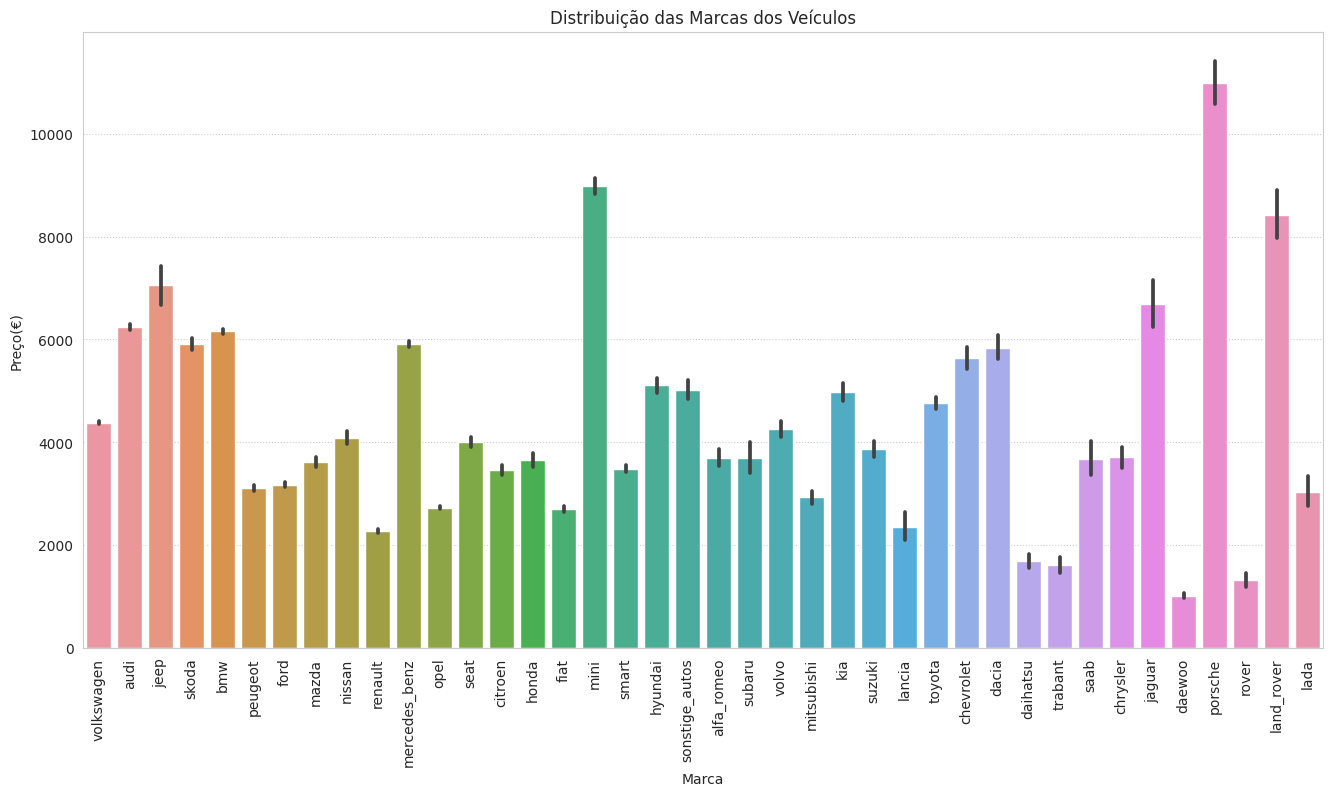

In [24]:
# Marca do veículo

plt.figure(figsize=(16, 8))
sns.barplot(data=df_copy, x='brand', y='price')
plt.xlabel('Marca')
plt.ylabel('Preço(€)')
plt.title('Distribuição das Marcas dos Veículos')
plt.xticks(rotation=90)  
plt.show()


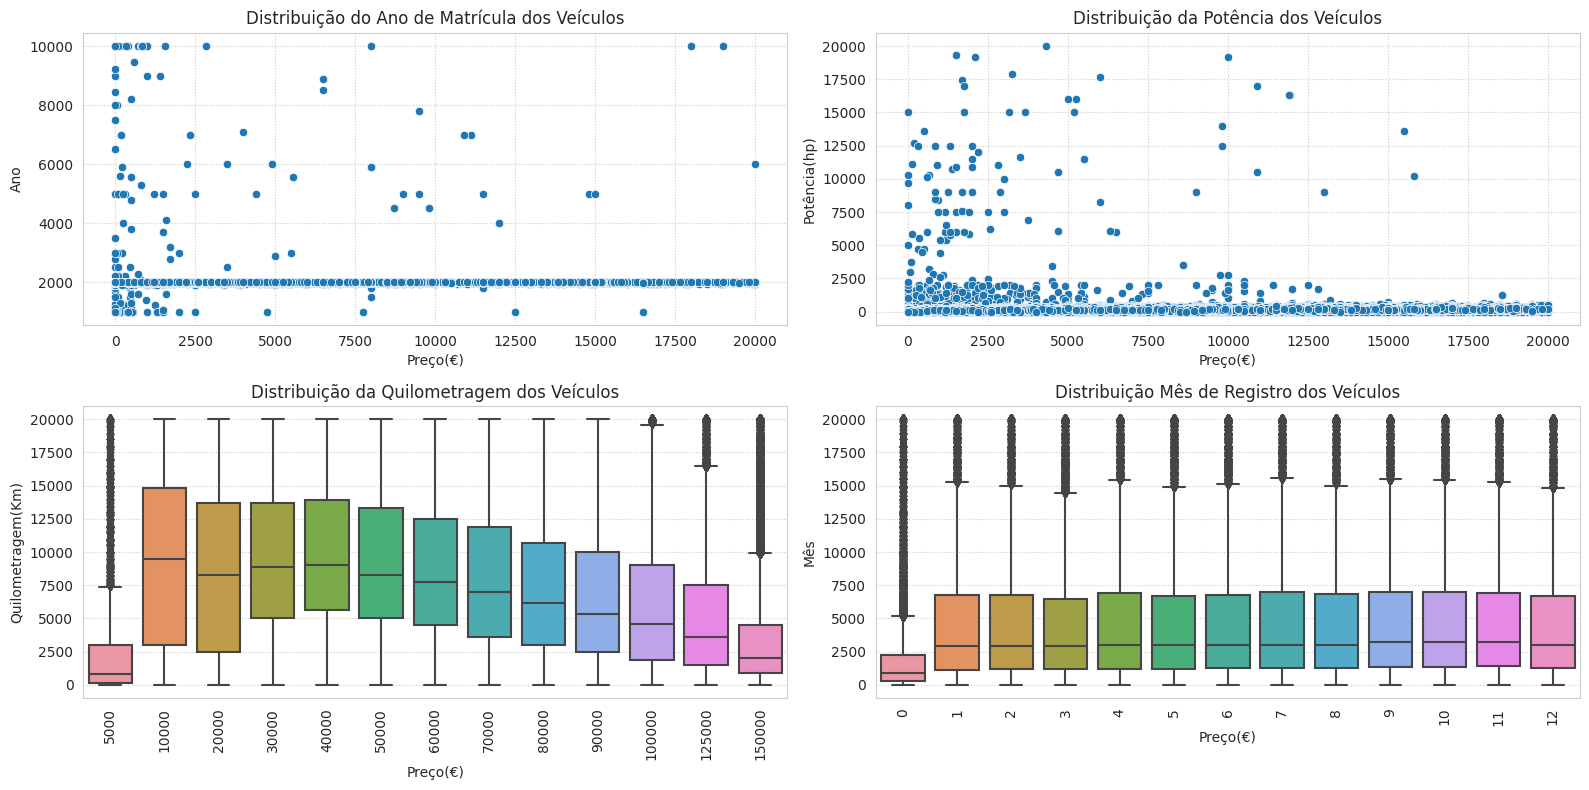

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
ax=axs[0,0]
sns.scatterplot(data=df_copy, x="price", y="registration_year", ax=axs[0,0])
axs[0,0].set_title('Distribuição do Ano de Matrícula dos Veículos')
axs[0,0].set_ylabel('Ano')
axs[0,0].set_xlabel('Preço(€)')

ax=axs[0,1]
sns.scatterplot(data=df_copy, x="price", y="power", ax=axs[0,1])
axs[0,1].set_title('Distribuição da Potência dos Veículos')
axs[0,1].set_ylabel('Potência(hp)')
axs[0,1].set_xlabel('Preço(€)')

ax=axs[1,0]
sns.boxplot(data=df_copy, x="mileage", y="price", ax=axs[1,0])
axs[1,0].set_title('Distribuição da Quilometragem dos Veículos')
axs[1,0].set_ylabel('Quilometragem(Km)')
axs[1,0].set_xlabel('Preço(€)')
axs[1,0].set_xticklabels(ax.get_xticklabels(), rotation=90)

ax=axs[1,1]
sns.boxplot(data=df_copy, x="registration_month", y="price", ax=axs[1,1])
axs[1,1].set_title('Distribuição Mês de Registro dos Veículos')
axs[1,1].set_ylabel('Mês')
axs[1,1].set_xlabel('Preço(€)')
axs[1,1].set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

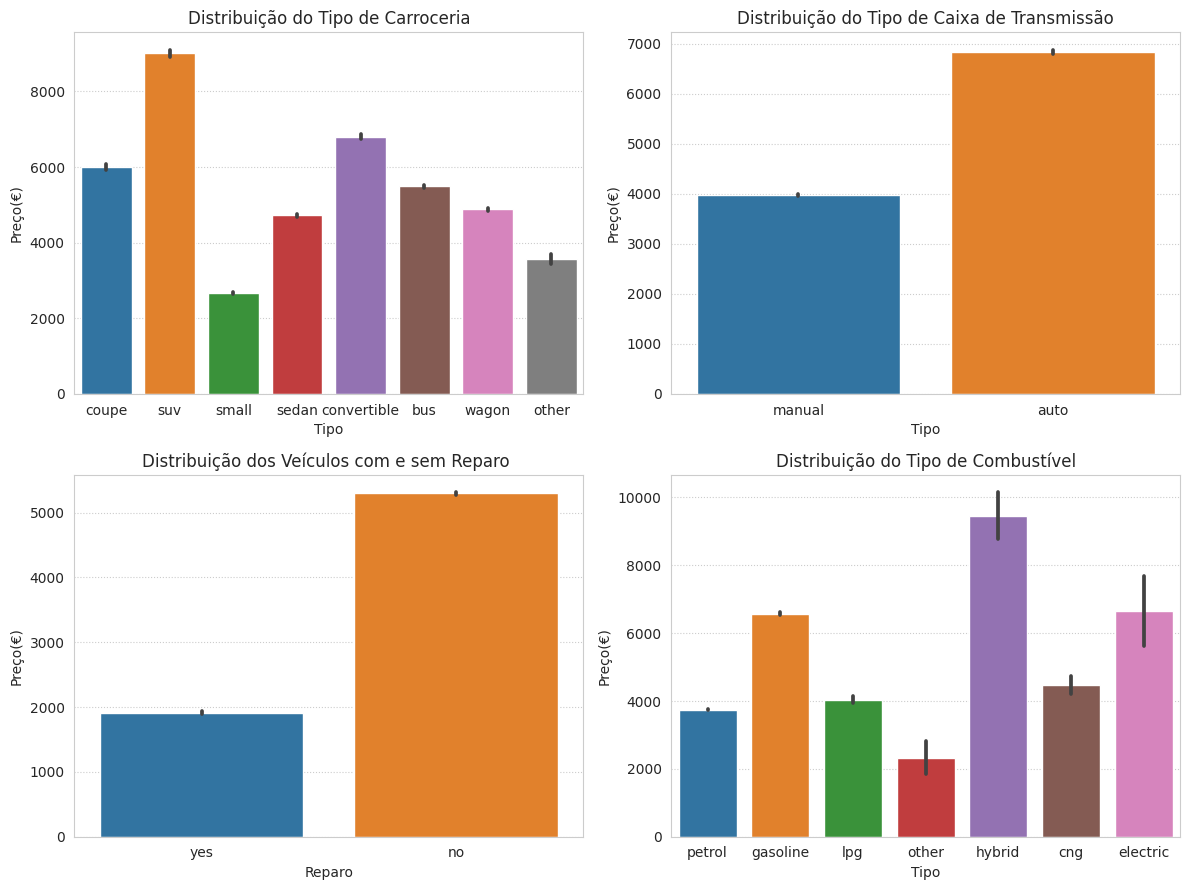

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
ax=axs[0,0]
sns.barplot(data=df_copy, x='vehicle_type', y='price', ax=axs[0,0])
axs[0,0].set_title('Distribuição do Tipo de Carroceria')
axs[0,0].set_ylabel('Preço(€)')
axs[0,0].set_xlabel('Tipo')

ax=axs[0,1]
sns.barplot(data=df_copy, x='gearbox', y='price', ax=axs[0,1])
axs[0,1].set_title('Distribuição do Tipo de Caixa de Transmissão')
axs[0,1].set_ylabel('Preço(€)')
axs[0,1].set_xlabel('Tipo')

ax=axs[1,0]
sns.barplot(data=df_copy, x='not_repaired', y='price', ax=axs[1,0])
axs[1,0].set_title('Distribuição dos Veículos Com e Sem Reparo ')
axs[1,0].set_ylabel('Preço(€)')
axs[1,0].set_xlabel('Reparo')

ax=axs[1,1]
sns.barplot(data=df_copy, x='fuel_type', y='price', ax=axs[1,1])
axs[1,1].set_title('Distribuição do Tipo de Combustível')
axs[1,1].set_ylabel('Preço(€)')
axs[1,1].set_xlabel('Tipo')

plt.tight_layout()
plt.show()

### Estatística Descritiva

In [30]:
# Descrição das variáveis numéricas
df_copy.describe()

,price,registration_year,power,mileage,registration_month
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


In [57]:
df_copy.var(numeric_only=True)

price                 2.037763e+07
registration_year     8.141084e+03
power                 3.604318e+04
mileage               1.436815e+09
registration_month    1.388621e+01
dtype: float64

### Teste de hipóteses

#### Verificando tamanho das amostras

In [61]:
price = df_copy.price.count()
registration_year = df_copy.registration_year.count()
registration_month = df_copy.registration_month.count()
power = df_copy.power.count()
mileage = df_copy.mileage.count()


print(f'price : {price}')
print(f'registration_year : {registration_year}')
print(f'power : {power}')
print(f'mileage : {mileage}')
print(f'registration_month : {registration_month}')

price : 354369
registration_year : 354369
power : 354369
mileage : 354369
registration_month : 354369


In [63]:
gearbox = df_copy.gearbox.value_counts()
gearbox

manual    268251
auto       66285
Name: gearbox, dtype: int64

In [65]:
model = df_copy.model.value_counts()
model

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

In [67]:
fuel_type = df_copy.fuel_type.value_counts()
fuel_type

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [68]:
brand = df_copy.brand.value_counts()
brand

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

In [70]:
not_repaired = df_copy.not_repaired.value_counts()
not_repaired

no     247161
yes     36054
Name: not_repaired, dtype: int64

#### Verificando a variância das amostras

In [73]:
df_copy.groupby('registration_year').price.var()

registration_year
1000    1.130806e+07
1001             NaN
1039             NaN
1111    8.003333e+04
1200             NaN
            ...     
9000    5.198003e+05
9229             NaN
9450             NaN
9996             NaN
9999    2.591427e+07
Name: price, Length: 151, dtype: float64

In [75]:
df_copy.groupby('registration_month').price.var()

registration_month
0     7.822520e+06
1     2.202853e+07
2     2.047831e+07
3     2.077515e+07
4     2.162936e+07
5     2.062897e+07
6     2.101854e+07
7     2.158700e+07
8     2.037032e+07
9     2.139825e+07
10    2.070598e+07
11    2.155679e+07
12    1.998778e+07
Name: price, dtype: float64

In [76]:
df_copy.groupby('power').price.var()

power
0        9.277285e+06
1        5.418834e+06
2        2.063719e+07
3        2.917492e+06
4        4.422864e+06
             ...     
17932             NaN
19208             NaN
19211             NaN
19312             NaN
20000             NaN
Name: price, Length: 712, dtype: float64

In [ ]:
mileage = df_copy.mileage.count()

### Distribuição F

### Valores ausentes e outliers

In [ ]:
imputed_df.isna().sum()

In [ ]:
imputed_df

### Corrigindo dados duplicados

In [ ]:
imputed_df = imputed_df.drop_duplicates()

In [ ]:
imputed_df.duplicated().sum()

### Corrigindo tipagem dos dados

In [ ]:
imputed_df.info()

In [ ]:
imputed_df.loc[:,'price'] = imputed_df['price'].astype('float')

In [ ]:
imputed_df['registration_year'] = imputed_df['registration_year'].astype('int')
imputed_df['power'] = imputed_df['power'].astype('int')
imputed_df['mileage'] = imputed_df['mileage'].astype('int')
imputed_df['registration_month'] = imputed_df['registration_month'].astype('int')
imputed_df['number_of_pictures'] = imputed_df['number_of_pictures'].astype('int')
imputed_df['postal_code'] = imputed_df['postal_code'].astype('int')

In [ ]:
imputed_df.info()

**Conclusões**

Durante esta etapa, foram realizadas diversas transformações nos dados a fim de prepará-los para a análise, como a alteração dos nomes das colunas de CamelCase para snake_case, a imputação dos valores ausentes utilizando a moda das variáveis categóricas e a remoção de dados duplicados. Além disso, a tipagem das variáveis foi corrigida de acordo com a natureza de cada uma.

## Estatística Descritiva

### Distribuições

In [ ]:
imputed_df[['price', 'registration_year', 'power']].describe()

In [ ]:
fig, ax = plt.subplots(figsize=(12,4));
sns.boxplot(x='price', ax=ax, data=imputed_df);
plt.title('Distribuição do preço dos carros')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,4));
sns.boxplot(x='power', ax=ax, data=imputed_df);
plt.xlim(-5, 2000);
plt.title('Distribuição das potências dos carros')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,4));
sns.boxplot(x='registration_year', ax=ax, data=imputed_df);
plt.xlim(0,3000)
plt.title('Distribuição do ano de registro dos carros')
plt.show()

In [ ]:
Q3_registration_year, Q1_registration_year = np.percentile(imputed_df['registration_year'], [75 ,25])
IQR_registration_year = Q3_registration_year - Q1_registration_year
upper_bound_registration_year = Q3_registration_year+1.5*IQR_registration_year
lower_bound_registration_year = Q1_registration_year-1.5*IQR_registration_year

In [ ]:
noise = 0.1
upper_bound_registration_year_noise = upper_bound_registration_year + noise
lower_bound_registration_year_noise = lower_bound_registration_year - noise

imputed_df = imputed_df[(imputed_df['registration_year'] >= lower_bound_registration_year) & 
                        (imputed_df['registration_year'] <= upper_bound_registration_year)]


In [ ]:
imputed_df

In [ ]:
fig, ax = plt.subplots(figsize=(12,4));
sns.boxplot(x='registration_year', ax=ax, data=imputed_df);
plt.title('Distribuição do ano de registro dos carros sem outliers')
plt.show()

In [ ]:
print(f'Percentual de dados removidos: {((data.shape[0]-imputed_df.shape[0])/data.shape[0]):.2%}') 

In [ ]:
imputed_df.info()

In [ ]:
imputed_df['date_crawled_year'] = imputed_df['date_crawled'].dt.year
imputed_df['date_crawled_month'] = imputed_df['date_crawled'].dt.month

In [ ]:
imputed_df['date_created_year'] = imputed_df['date_created'].dt.year
imputed_df['date_created_month'] = imputed_df['date_created'].dt.month

In [ ]:
imputed_df['last_seen_year'] = imputed_df['last_seen'].dt.year
imputed_df['last_seen_month'] = imputed_df['last_seen'].dt.month

In [ ]:
imputed_df.drop(['date_crawled', 'date_created', 'last_seen'], axis=1, inplace=True)

**Conclusões**

Durante essa etapa, foi observado que as colunas numéricas possuíam muitos outliers, sobretudo a coluna registration_year, no entanto esta última apresentou uma quantidade expressiva de outliers com valores fora da realidade (ano de registro 3000), enquanto as colunas price e power possuíam valores possíveis apesar de estarem fora do comportamento dos dados. 

Considerando essa situação, optou-se por tratar os outliers somente da coluna registration_year. Para isso, utilizou-se o método do Intervalo Interquartil para encontrar os limites superior e inferior e, em seguida, acrescentou-se um pequeno ruído de 0.1 ao valor do limite superior e subtraiu-se 0.1 do valor do limite inferior.

Essa técnica permitiu remover os valores extremos que estavam muito fora da realidade e, assim, garantir uma análise mais precisa e confiável. 

## Treinamento do modelo

In [ ]:
features = imputed_df.drop(['price', 'model', 'brand', 'postal_code'], axis=1)
target = imputed_df['price']

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [ ]:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345)

In [ ]:
def preprocess_data(data):
    # Define columns
    cat_cols = ['vehicle_type', 'gearbox', 'fuel_type', 'not_repaired']
    one_hot_cols = [x for x in cat_cols if data[x].nunique()<=3]
    encoding_cols = list(set(cat_cols) - set(one_hot_cols))
    numerical_cols = ['power', 'mileage']
    
    # Standardize numerical features
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
    
    # One-hot encode categorical features with <=3 unique values
    encoder = ce.OneHotEncoder(cols=one_hot_cols)
    data = encoder.fit_transform(data)
    
    # Label encode remaining categorical features
    encoder = LabelEncoder()
    for col in encoding_cols:
        data[col] = encoder.fit_transform(data[col])
        
    return data


In [ ]:
train_encoded, valid_encoded, test_encoded = features_train.copy(), features_valid.copy(), features_test.copy()

In [ ]:
train_encoded = preprocess_data(train_encoded)
valid_encoded = preprocess_data(valid_encoded)
test_encoded = preprocess_data(test_encoded)

In [ ]:
def build_pipeline(model_name, X_train, y_train, X_valid, y_valid):
    if model_name == 'RandomForestRegressor':
        model = RandomForestRegressor()
        param_grid = {'n_estimators': [1, 11],
                      'max_depth': [1, 6]}
    elif model_name == 'XGBRegressor':
        model = xgb.XGBRegressor()
        param_grid = {'n_estimators': [1, 11],
                      'max_depth': [1, 6],
                      'learning_rate': [0.1, 1]}
    elif model_name == 'LGBMRegressor':
        model = lgb.LGBMRegressor()
        param_grid = {'n_estimators': [1, 11],
                      'max_depth': [1, 26],
                      'learning_rate': [0.1, 1]}
    elif model_name == 'CatBoostRegressor':
        model = CatBoostRegressor(silent=True)
        param_grid = {'n_estimators': [1, 13],
                      'max_depth': [1, 6]}
    else:
        raise ValueError('Invalid model name')

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    best_model = grid_search.best_estimator_
    predicted_valid = best_model.predict(X_valid)
    mse = mean_squared_error(y_valid, predicted_valid)**0.5
    r2 = r2_score(y_valid, predicted_valid)
    print(f'Model: {model_name}\nMSE: {mse:.2f}\nR2 score: {r2:.2f}\n')

    return best_model

### Floresta Aleatória

In [ ]:
%%time

model_name = 'RandomForestRegressor'
best_model = build_pipeline(model_name, train_encoded, target_train, valid_encoded, target_valid)

### XGBoost

In [ ]:
%%time

model_name = 'XGBRegressor'
best_model = build_pipeline(model_name, train_encoded, target_train, valid_encoded, target_valid)

### LightGBM

In [ ]:
%%time

model_name = 'LGBMRegressor'
best_model = build_pipeline(model_name, train_encoded, target_train, valid_encoded, target_valid)

 ### CatBoost 

In [ ]:
%%time

model_name = 'CatBoostRegressor'
best_model = build_pipeline(model_name, train_encoded, target_train, valid_encoded, target_valid)

**Conclusões**

Durante essa etapa, foram realizadas diversas etapas, como a separação dos dados em features e target, a separação dos dados em conjunto de treino, validação e teste e a criação de funções como preprocess_data e build_pipeline.

A função preprocess_data foi criada para tratar os dados de acordo com a tipagem dos dados, aplicando OneHotEncoder, LabelEncoder e StandardScaler de maneira cuidadosa para evitar vazamento de dados.

A função build_pipeline, por sua vez, foi criada para automatizar o treinamento dos modelos, permitindo que sejam testados diversos algoritmos de regressão e seus hiperparâmetros, com a escolha do melhor modelo com base nas métricas: erro quadrático médio e o score R2.

Ao treinar os modelos RandomForestRegressor, XGBRegressor, LGBMRegressor e CatBoostRegressor , foi possível identificar que o CatBoostRegressor apresentou o melhor desempenho, com os hiperparâmetros max_depth igual a 6 e n_estimators igual a 13. O modelo apresentou um MSE de 2208.39 e um score R2 de 0.76.

O tempo de execução indica que o processo de treinamento do modelo CatBoostRegressor evou cerca de 9.47 segundos para ser executado pelo processador, com uma sobrecarga do sistema de 51.7 milissegundos. O tempo total de execução foi de 9.53 segundos.O tempo de execução "Wall time" de 11.3 segundos indica o tempo total decorrido, incluindo não apenas o tempo de execução do processador, mas também qualquer atraso relacionado à sobrecarga do sistema ou outros processos em segundo plano. Esses valores parecem estar dentro do tempo razoável para o treinamento do modelo.

## Avaliando modelo escolhido com conjunto de Teste

In [ ]:
cat = CatBoostRegressor(max_depth=6, n_estimators=13)
cat.fit(train_encoded, target_train)
cat_pred_train = cat.predict(train_encoded)
cat_pred_test = cat.predict(test_encoded)


cat_mse_train = mean_squared_error(target_train, cat_pred_train)**0.5
cat_mse_test = mean_squared_error(target_test, cat_pred_test)**0.5
cat_r2_test_train = r2_score(target_train, cat_pred_train)
cat_r2_test = r2_score(target_test, cat_pred_test)

print("Gradient Boosting no conjunto de treinamento:")
print(f"MSE: {cat_mse_train:.2f}")
print(f"R2 score: {cat_r2_test_train:.2f}")
print()
print("Gradient Boosting no conjunto de teste:")
print(f"MSE: {cat_mse_test:.2f}")
print(f"R2 score: {cat_r2_test:.2f}")

**Conclusões**

Os resultados do modelo CatBoostRegressor são muito bons, com um MSE de 2092.16 no conjunto de treinamento e 2207.71 no conjunto de teste, indicando que o modelo tem uma boa capacidade de generalização para dados não vistos anteriormente. O R2 score também é alto, com um valor de 0.78 para o conjunto de treinamento e 0.76 para o conjunto de teste.

Esses resultados sugerem que o modelo CatBoostRegressor é capaz de fazer boas previsões para o preço dos carros com base nas características fornecidas.

## Prova real

In [ ]:
features = preprocess_data(features)

In [ ]:
%%time 

lr = LinearRegression()
lr.fit(features, target)
lr_pred = lr.predict(features)
lr_mse = mean_squared_error(target, lr_pred)**0.5
lr_r2 = r2_score(target, lr_pred)
print("Linear Regression:")
print(f"MSE: {lr_mse:.2f}")
print(f"R2 score:: {lr_r2:.2f}")

In [ ]:
%%time

cat = CatBoostRegressor(max_depth=6, n_estimators=13)
cat.fit(features, target)
cat_pred = cat.predict(features)
cat_mse = mean_squared_error(target, cat_pred)**0.5
cat_r2 = r2_score(target, cat_pred)
print("Gradient Boosting:")
print(f"MSE: {cat_mse:.2f}")
print(f"R2 score: {cat_r2:.2f}")

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(target, lr_pred, label='Linear Regression')
ax.scatter(target, cat_pred, label='Cat Boost Regressor')
ax.set_xlabel('True values')
ax.set_ylabel('Predicted values')
plt.title('Plot the predicted values against the true values')
plt.legend()
plt.show()

**Conclusões**

Os resultados da aplicação do modelo de regressão linear e do modelo CatBoostRegressor no dataset original mostram que o modelo CatBoostRegressor superou significativamente o modelo de regressão linear em termos de desempenho.

O modelo de regressão linear obteve um MSE de 3422.70 e um R2 score de 0.42. Enquanto o modelo CatBoostRegressor obteve um MSE de 2088.84 e um R2 score de 0.78, indicando uma melhoria significativa na precisão da previsão.

Além disso, os tempos de execução do modelo foram razoáveis, com o modelo de regressão linear levando 228ms para ser executado e o modelo CatBoostRegressor levando 1.17s. Isso mostra que o modelo CatBoostRegressor ainda é uma opção viável para ser utilizado em aplicações práticas, mesmo com a necessidade de mais tempo de execução.

O gráfico corrobora com os resultados das métricas, onde o modelo CatBoostRegressor tem um desempenho geral melhor, pois seus preços previstos estão mais próximos dos preços reais e são distribuídos de maneira mais uniforme em torno da linha diagonal que representa previsões perfeitas.

Com base nesses resultados, podemos concluir que o modelo CatBoostRegressor é uma opção mais adequada para previsão do preço dos carros no mercado em comparação com o modelo de regressão linear, e pode ser utilizado pela empresa para estimar o preço de mercado dos carros com base nas suas características.

## Conclusões

Neste projeto, foi realizado um estudo de previsão de preços de mercado de carros a partir de um conjunto de  dados históricos, especificações técnicas, versões de acabamento e preços fornecidos pela empresa Rusty Bargain. Foi realizada a limpeza dos dados, tratamento de valores ausentes, duplicados e outliers, além de uma análise exploratória dos dados para entender as características do conjunto de dados.

Foi feita uma separação dos dados em conjuntos de treino, validação e teste, seguida da criação de uma função de pré-processamento que tratou as variáveis categóricas binárias, categóricas politômicas, e numéricas com o uso de técnicas como one-hot encoding, label encoding e standard scaling.

Diferentes modelos de regressão foram testados, incluindo RandomForestRegressor, XGBRegressor, LGBMRegressor e CatBoostRegressor. Foi utilizado um processo de tuning de hiperparâmetros para encontrar o melhor modelo e os resultados mostraram que o CatBoostRegressor teve um melhor desempenho em termos de MSE e R2 score.

O modelo final foi aplicado ao conjunto de dados original e comparado com a regressão linear. Os resultados mostraram que o modelo de CatBoostRegressor teve um desempenho superior, obtendo um MSE de 2077.46 e um R2 score de 0.79, enquanto a regressão linear teve um MSE de 3428.72 e um R2 score de 0.43.